#  Проект: Обучение с учителем: качество модели

**Цель проекта**: разработать решение, которое позволит персонализировать предложения постоянным клиентам интернет-магазина, чтобы увеличить их покупательскую активность

**Задачи**:
1. Построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца
2. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения

### Описание данных

#### market_file.csv (данные о поведении покупателя на сайте)

* id — номер покупателя в корпоративной базе данных.
* Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
* Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
* Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
* Маркет_актив\_6\_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
* Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
* Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
* Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
* Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
* Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
* Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
* Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
* Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

#### market_money.csv (данные о выручке магазина с покупателя)

* id — номер покупателя в корпоративной базе данных.
* Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
* Выручка — сумма выручки за период.

#### market_time.csv (данные о времени (в минутах) нахождения на сайте)

* id — номер покупателя в корпоративной базе данных.
* Период — название периода, во время которого зафиксировано общее время.
* минут — значение времени, проведённого на сайте, в минутах.

#### money.csv (данные о среднемесячной прибыли)

* id — номер покупателя в корпоративной базе данных.
* Прибыль — значение прибыли.

### Загрузка данных

In [1]:
!pip install phik
!pip install shap
!pip install --upgrade scikit-learn
!pip install matplotlib==3.5.0 -q

     |████████████████████████████████| 539 kB 1.2 MB/s eta 0:00:01


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import phik
import numpy as np
import shap
import seaborn as sns
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [3]:
behavior_df = pd.read_csv('/datasets/market_file.csv')
behavior_df.info()
behavior_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [4]:
revenue_df = pd.read_csv('/datasets/market_money.csv')
revenue_df.info()
revenue_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [5]:
time_df = pd.read_csv('/datasets/market_time.csv')
display(time_df.info())
time_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [6]:
money_df = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
money_df.info()
money_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Данные во всех таблицах соответствуют описанию

### Предобработка данных

behavior_df, revenue_df, time_df, money_df - 4 датафрейма, выполним в них предобработку данных - приведем названия столбцов к единому виду, обработаем пропуски и дубликаты, при необходимости изменим тип данных в столбцах

#### Обработка названий столбцов

In [7]:
list_df = [behavior_df, revenue_df, time_df, money_df]
for i in list_df:
    i.columns = i.columns.str.lower().str.replace(' ', '_')
    print(i.columns)

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')
Index(['id', 'период', 'выручка'], dtype='object')
Index(['id', 'период', 'минут'], dtype='object')
Index(['id', 'прибыль'], dtype='object')


#### Обработка пропусков

In [8]:
for i in list_df:  
    print(i.isna().sum())

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64
id         0
период     0
выручка    0
dtype: int64
id        0
период    0
минут     0
dtype: int64
id         0
прибыль    0
dtype: int64


Ожидаемых пропусков в датафреймах не найдено

#### Обработка дубликатов

In [9]:
for i in list_df:  
    print(i.duplicated().sum())

0
0
0
0


Явных дубликатов не обнаружено

In [10]:
for i in list_df:
    for col in i.select_dtypes('object').columns:
        print(col)
        print(i[col].unique())

покупательская_активность
['Снизилась' 'Прежний уровень']
тип_сервиса
['премиум' 'стандартт' 'стандарт']
разрешить_сообщать
['да' 'нет']
популярная_категория
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']
период
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
период
['текущий_месяц' 'предыдцщий_месяц']


In [11]:
behavior_df['тип_сервиса'] = behavior_df['тип_сервиса'].replace('стандартт', 'стандарт')
behavior_df['тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [12]:
time_df['период'] = time_df['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')
time_df['период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

Нашли неявный дубликат в столбце тип_сервиса датафрейма behavior_df, а также опечатку в столбце период датафрейма time_df

#### Вывод

На этапе предообработки данных привели названия столбцов к змеиной нотации, ожидаемые пропуски и явные дубликаты не обнаружены. Обработали неявный дубликат и опечатку. Типы данных столбцов в норме.

### Исследовательский аналих данных

Для исследовательского анализа проведем отбор клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период

In [13]:
revenue_df.head() #здесь находятся id актуальных клиентов

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [14]:
display(behavior_df.shape)
behavior_df = behavior_df[behavior_df['id'].isin(revenue_df['id'])]
behavior_df.shape #получается, что все клиенты в основном датафрейме совершали покупки за последние 3 месяца

(1300, 13)

(1300, 13)

#### Количественные признаки

##### behavior_df

In [15]:
behavior_df.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


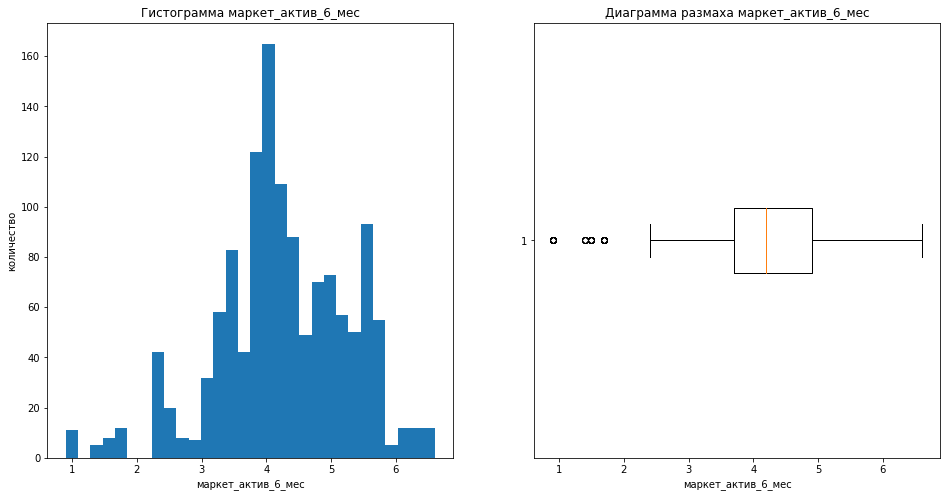

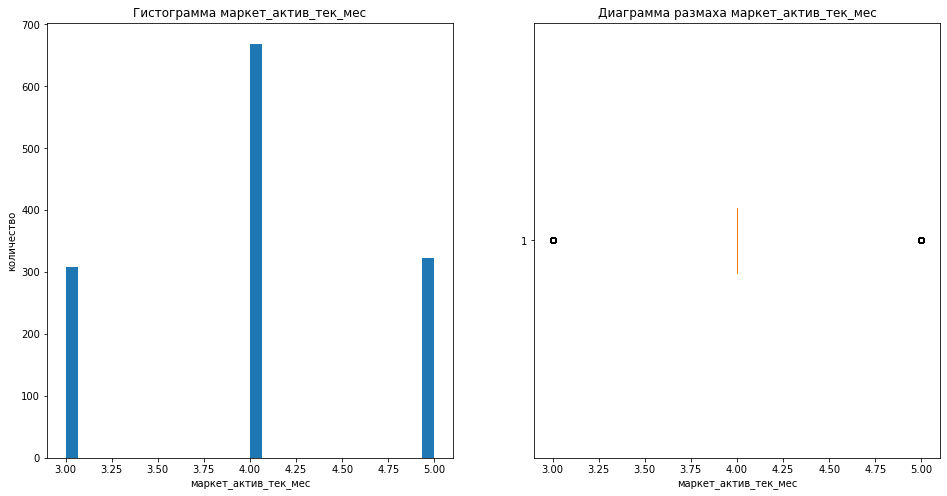

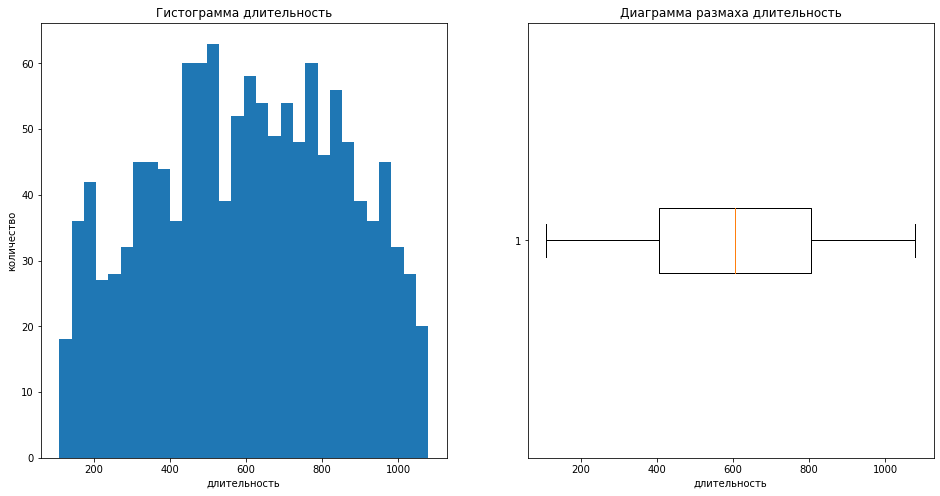

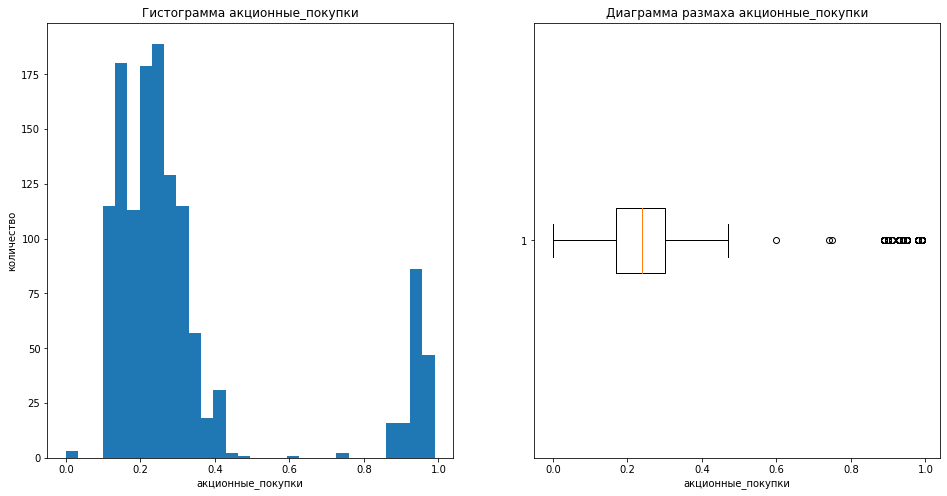

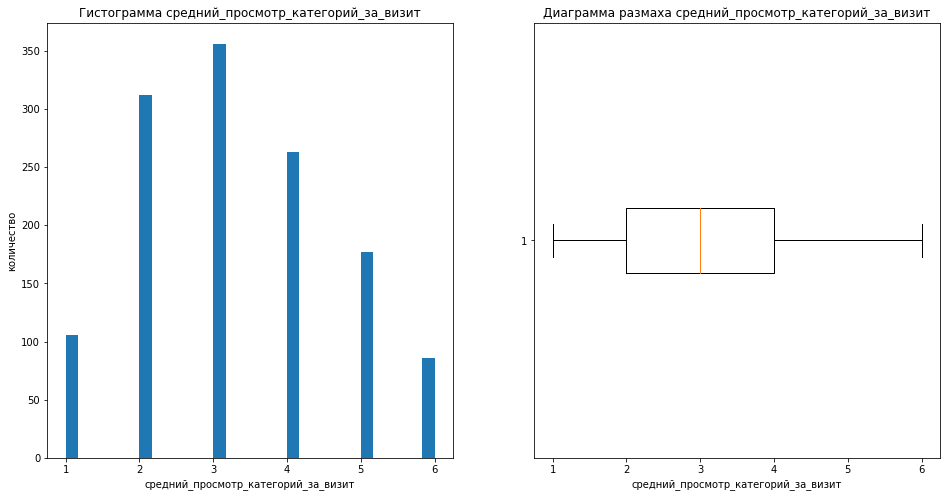

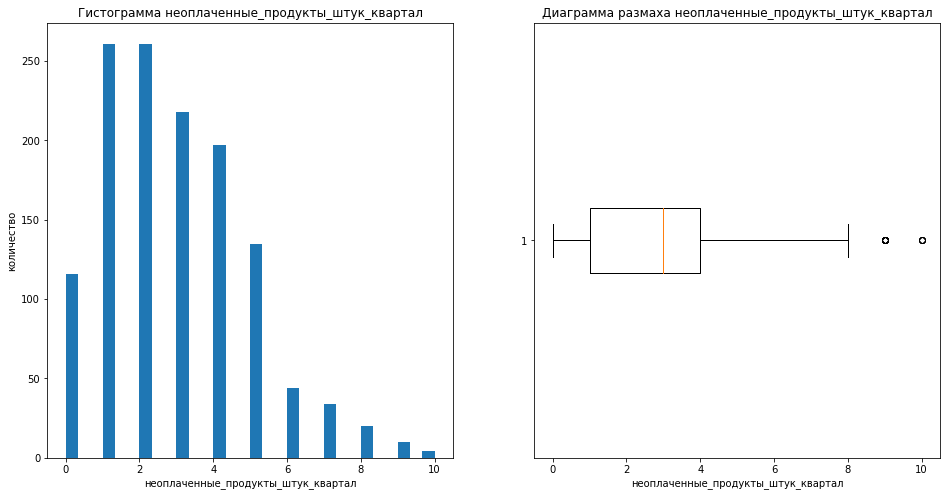

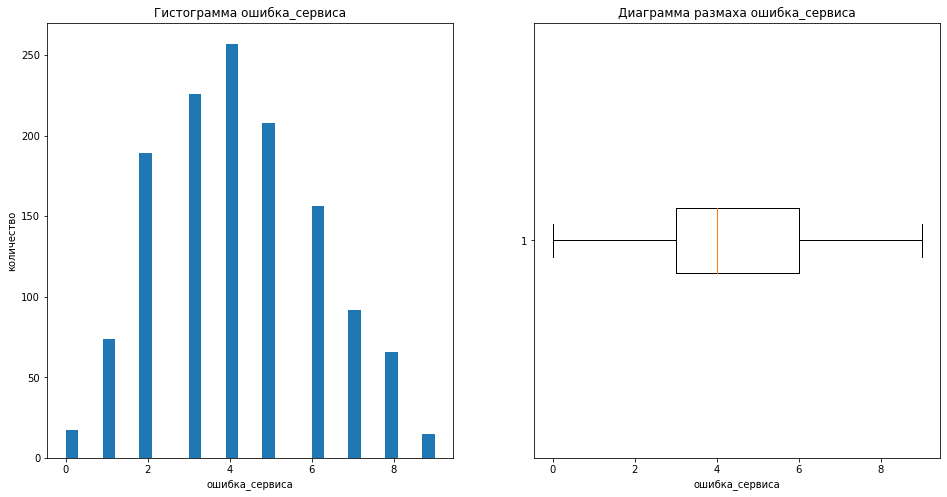

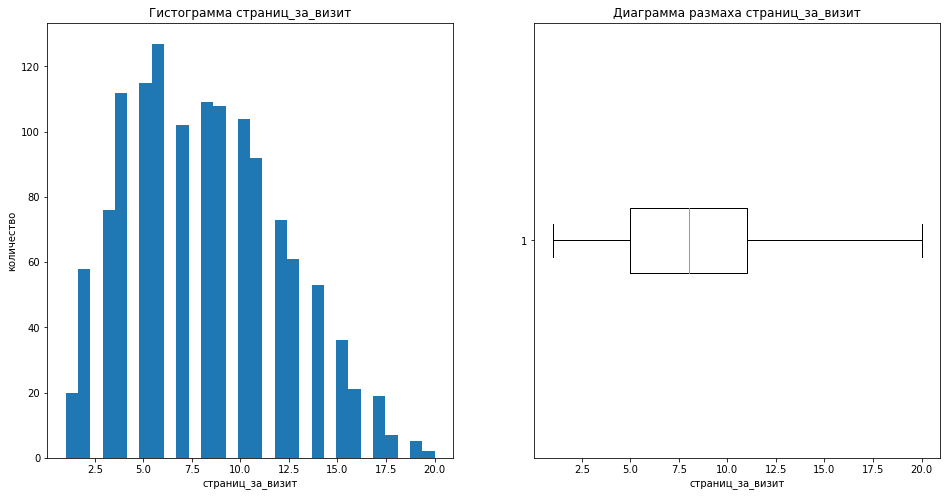

In [16]:
#строим графики кол-ных признаков датафрейма с данными о поведение покупателя (behavior_df)
for col in behavior_df.select_dtypes(exclude='object').drop('id', axis=1).columns:
    fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
    ax[0].hist(data=behavior_df, x=col, bins=30)
    ax[0].set_title(f'Гистограмма {col}')
    ax[0].set_xlabel(col)
    ax[0].set_ylabel('количество')
    ax[1].boxplot(data=behavior_df, x=col, vert=False)
    ax[1].set_title(f'Диаграмма размаха {col}')
    ax[1].set_xlabel(col)
    plt.show()

##### revenue_df

In [17]:
revenue_df.describe()

,id,выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


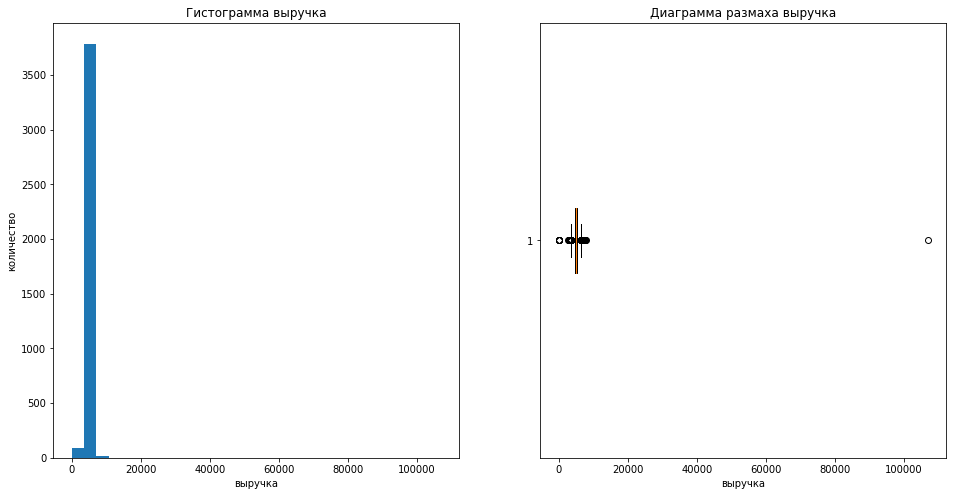

In [18]:
#строим графики кол-ных признаков датафрейма с данными о выручке магазина (revenue_df)
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
ax[0].hist(data=revenue_df, x='выручка', bins=30)
ax[0].set_title('Гистограмма выручка')
ax[0].set_xlabel('выручка')
ax[0].set_ylabel('количество')
ax[1].boxplot(data=revenue_df, x='выручка', vert=False)
ax[1].set_title('Диаграмма размаха выручка')
ax[1].set_xlabel('выручка')
plt.show()

In [19]:
revenue_df['выручка'].sort_values(ascending=False).head()

98      106862.2
435       7799.4
262       7605.3
1481      7557.0
2388      7547.8
Name: выручка, dtype: float64

Видим одно аномальное значение - его следует удалить

In [20]:
revenue_df = revenue_df[(revenue_df['выручка'] < 10000) & (revenue_df['выручка'] > 0)] #заодно и нулевые уберем
revenue_df['выручка'].sort_values(ascending=False).head()

435     7799.4
262     7605.3
1481    7557.0
2388    7547.8
566     7467.9
Name: выручка, dtype: float64

##### time_df

In [21]:
time_df.describe()

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


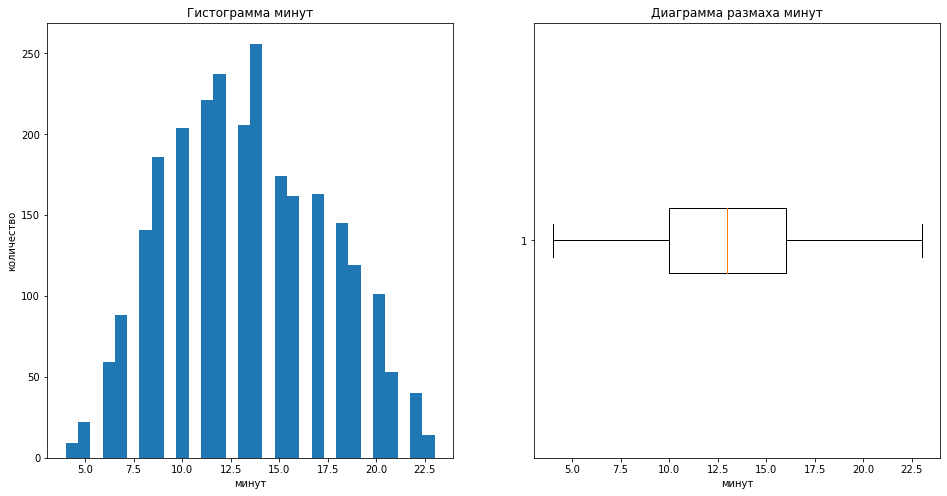

In [22]:
#строим графики кол-ных признаков датафрейма с данными о времени, проведенном на сайте магазина (time_df)
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
ax[0].hist(data=time_df, x='минут', bins=30)
ax[0].set_title('Гистограмма минут')
ax[0].set_xlabel('минут')
ax[0].set_ylabel('количество')
ax[1].boxplot(data=time_df, x='минут', vert=False)
ax[1].set_title('Диаграмма размаха минут')
ax[1].set_xlabel('минут')
plt.show()

##### money_df

In [23]:
money_df.describe()

,id,прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


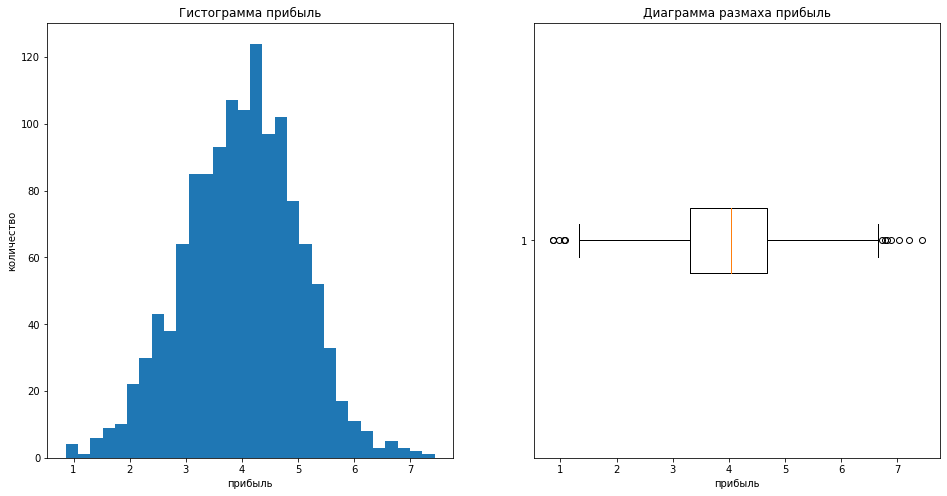

In [24]:
#строим графики кол-ных признаков датафрейма с данными о среднемесячной прибыли с клиента (money_df)
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
ax[0].hist(data=money_df, x='прибыль', bins=30)
ax[0].set_title('Гистограмма прибыль')
ax[0].set_xlabel('прибыль')
ax[0].set_ylabel('количество')
ax[1].boxplot(data=money_df, x='прибыль', vert=False)
ax[1].set_title('Диаграмма размаха прибыль')
ax[1].set_xlabel('прибыль')
plt.show()

#### Категориальные признаки

##### behavior_df

Прежний уровень    802
Снизилась          498
Name: покупательская_активность, dtype: int64

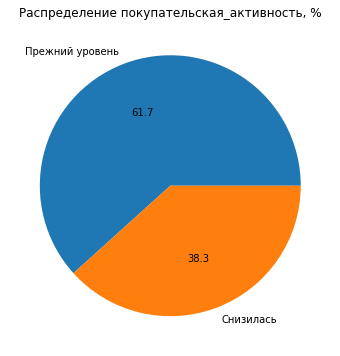

стандарт    924
премиум     376
Name: тип_сервиса, dtype: int64

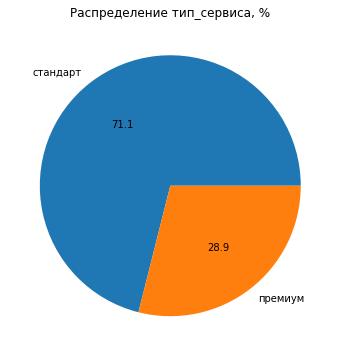

да     962
нет    338
Name: разрешить_сообщать, dtype: int64

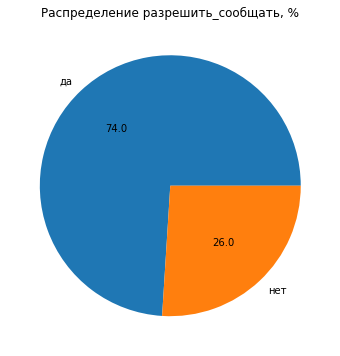

Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: популярная_категория, dtype: int64

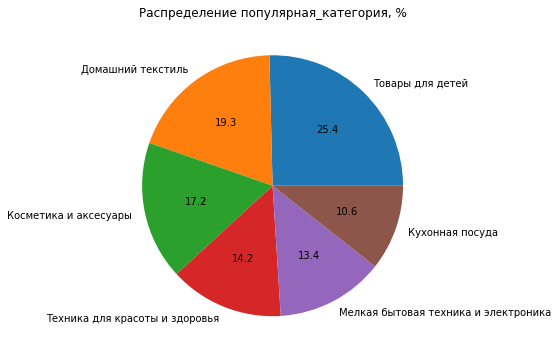

In [25]:
for col in behavior_df.select_dtypes('object').columns:
    display(behavior_df[col].value_counts())
    behavior_df[col].value_counts().plot(kind='pie', title=f'Распределение {col}, %', autopct='%.1f', figsize=(10, 6))
    plt.ylabel(None)
    plt.show()

##### revenue_df

текущий_месяц          1299
препредыдущий_месяц    1297
предыдущий_месяц       1297
Name: период, dtype: int64

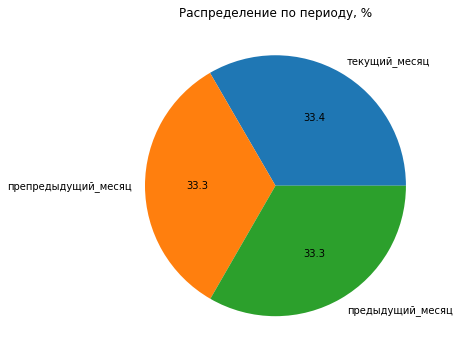

In [26]:
display(revenue_df['период'].value_counts())
revenue_df['период'].value_counts().plot(kind='pie', title='Распределение по периоду, %', autopct='%.1f', figsize=(10, 6))
plt.ylabel(None)
plt.show()

##### time_df

предыдущий_месяц    1300
текущий_месяц       1300
Name: период, dtype: int64

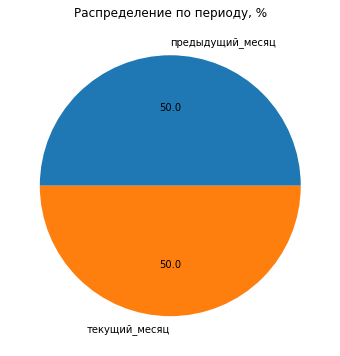

In [27]:
display(time_df['период'].value_counts())
time_df['период'].value_counts().plot(kind='pie', title='Распределение по периоду, %', autopct='%.1f', figsize=(10, 6))
plt.ylabel(None)
plt.show()

#### Вывод

На этапе исследовательского анализа были построены графики к количественным и категориальным признакам. Обнаружено и удалено одно аномальное значение. Большинство количественых признаков распределено нормально (исключение составил признак акционные покупки). Категориальные признаки имеют близкое к равному распределение по долям.

### Объединение таблиц

Для объединения таблиц, необходимо сначала разложить по столбцам с месяцами датафреймы revenue_df, time_df.

In [28]:
revenue_df_pivot = revenue_df.pivot_table(index='id', columns='период', values='выручка').dropna().reset_index()
revenue_df_pivot.columns.name = None
revenue_df_pivot = revenue_df_pivot.rename(
    columns={
        'id': 'id',
        'предыдущий_месяц': 'выручка_предыдущий_месяц',
        'препредыдущий_месяц': 'выручка_препредыдущий_месяц',
        'текущий_месяц': 'выручка_текущий_месяц'
    }).reindex(columns=['id', 'выручка_препредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц'])
revenue_df_pivot.head()

,id,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц
0,215349,4472.0,5216.0,4971.6
1,215350,4826.0,5457.5,5058.4
2,215351,4793.0,6158.0,6610.4
3,215352,4594.0,5807.5,5872.5
4,215353,5124.0,4738.5,5388.5


In [29]:
time_df_pivot = time_df.pivot_table(index='id', columns='период', values='минут').dropna().reset_index()
time_df_pivot.columns.name = None
time_df_pivot = time_df_pivot.rename(
    columns={
        'id': 'id',
        'предыдущий_месяц': 'минут_предыдущий_месяц',
        'текущий_месяц': 'минут_текущий_месяц'
    })
time_df_pivot.head()

,id,минут_предыдущий_месяц,минут_текущий_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


In [30]:
df_full = revenue_df_pivot.merge(time_df_pivot, on='id', how='left')
df_full = behavior_df.merge(df_full, on='id', how='right')
df_full.set_index('id', inplace=True)
display(df_full.head())
df_full.shape

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10


(1296, 17)

На данном подготовительном этапе создали объединенную таблицу с признаками. Эту таблицу будем использовать для обучения моделей.

### Корреляционный анализ

In [31]:
phik_overview = df_full.phik_matrix()

interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_препредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц']


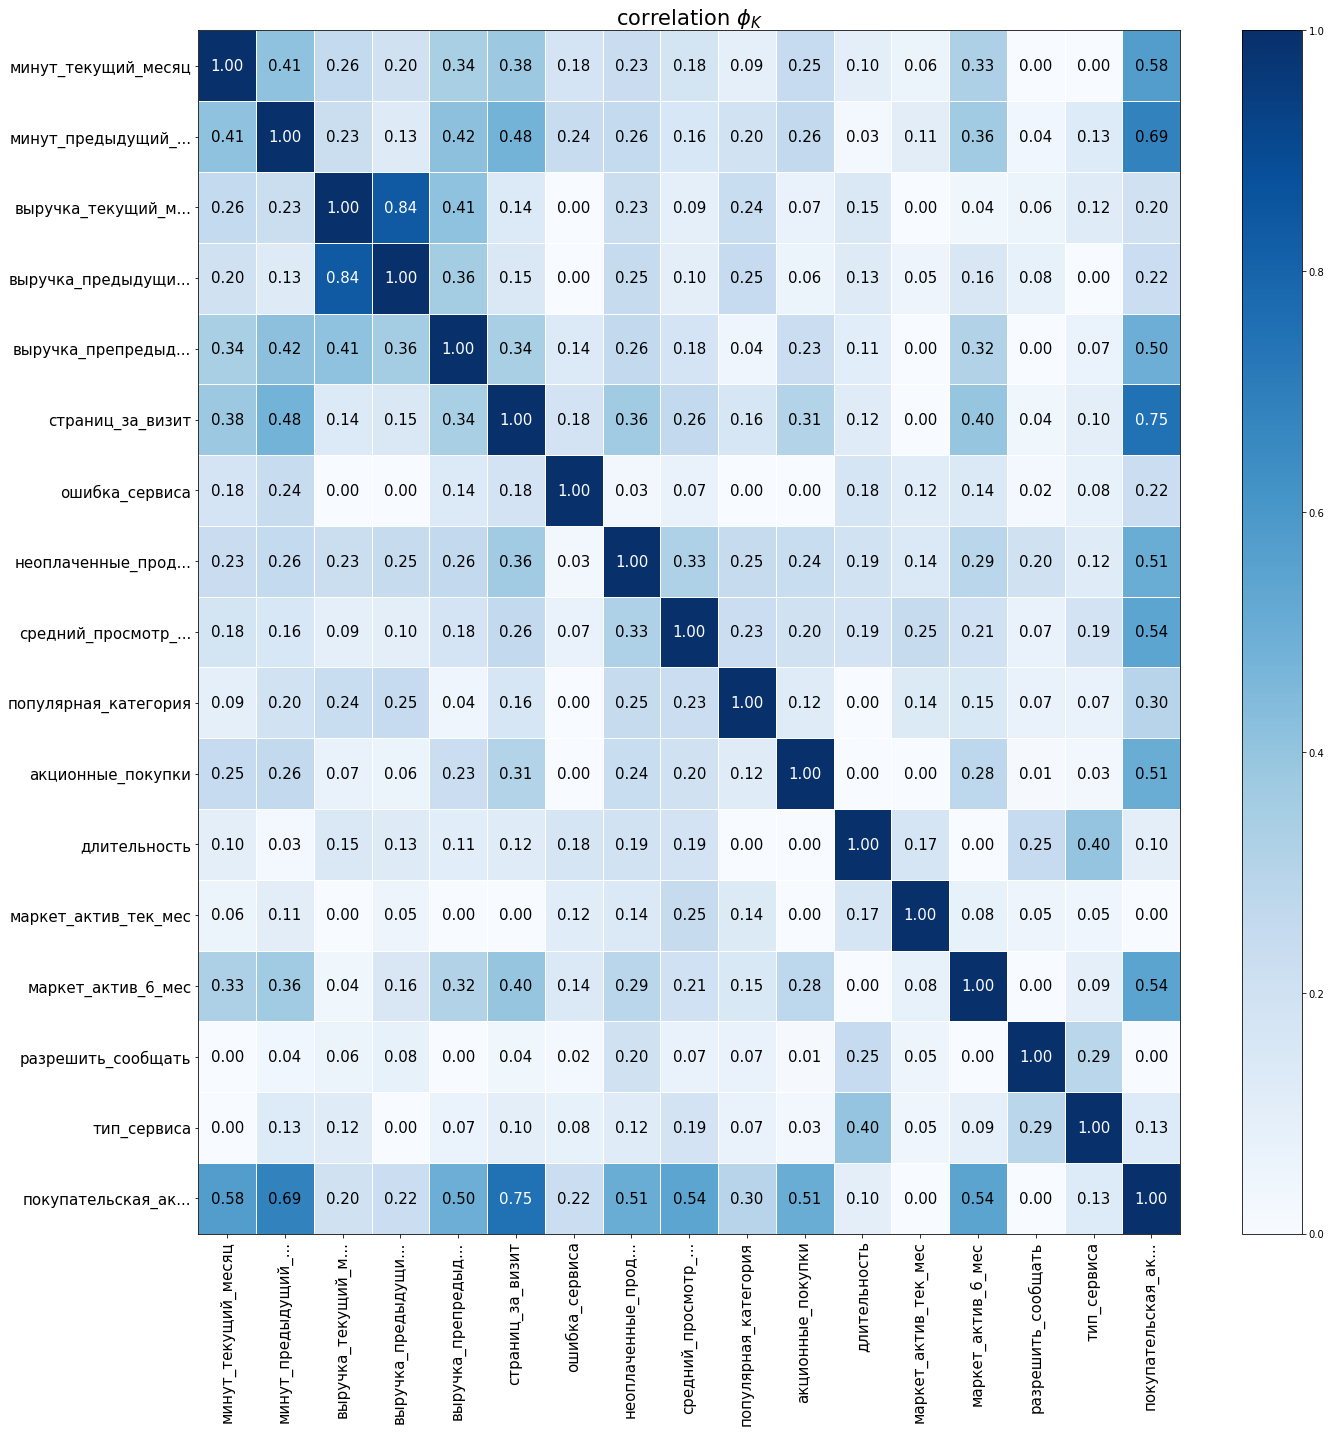

In [32]:
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(20, 20))

На этапе корреляционного анализа построена матрица взаимосвязи между признаками. Обнаружена высокая корреляция между признаками выручка_предыдущий_период и выручка_текущий_период (0.84). Значение не превышает 0.9 поэтому принято решение не убирать признак.

### Использование пайплайнов

#### Подготовка данных

In [33]:
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    df_full.drop('покупательская_активность', axis=1),
    df_full['покупательская_активность'],
    random_state = RANDOM_STATE,
    stratify = df_full['покупательская_активность']
    )

ohe_col = ['разрешить_сообщать', 'популярная_категория']
ord_col = ['тип_сервиса']
num_col = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки',
           'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал',
           'ошибка_сервиса', 'страниц_за_визит', 'выручка_препредыдущий_месяц',
           'выручка_предыдущий_месяц', 'выручка_текущий_месяц', 'минут_предыдущий_месяц',
           'минут_текущий_месяц']

In [34]:
label_encoder = LabelEncoder() #кодируем целевой признак

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [35]:
#пайплайн для подготовки признаков из списка ohe_col
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))
    ]
) #вот здесь код не работает если использовать hundle_unknown='ignore'.

In [36]:
#пайплайн для подготовки признаков из списка ord_col
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(
        categories=[
            ['стандарт', 'премиум'],
        ],
        handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [37]:
#общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_col),
    ('ord', ord_pipe, ord_col),
    ('num', MinMaxScaler(), num_col)
    ],
    remainder='passthrough'
)

In [38]:
#итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

#### Обучение моделей

In [39]:
#список словарей для моделей
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__max_features': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': range(1, 5),
        'models__kernel': ['rbf', 'linear', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }
]

In [40]:
#подбор гиперпараметров
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse_output=False))]),
                                                                               ['разрешить_сообщать',
                                                                                'популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_befo...
                                                               MinMaxScaler()]},
                                        {'models': [LogisticRegression(random_state=42)],
                                         'models__C': range(1, 6),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__C': range(1, 5),
                                         'models__kernel': ['rbf', 'linear',
                                                            'sigmoid'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=42, scoring='roc_auc')

В качестве метрики была выбрана roc-auc, так как: 
* она подходит для решения задач бинарной классификации
* ее можно использовать в случае, когда объектов с одним значением целевого признака больше, чем с другими
* она учитывает работу модели при всех возможных значениях порогов

#### Выбор лучшей модели

In [41]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                            

In [42]:
pd.set_option('display.max_colwidth', None)

In [43]:
result = pd.DataFrame(randomized_search.cv_results_)
result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')

,rank_test_score,param_models,mean_test_score,params
1,1,"SVC(probability=True, random_state=42)",0.895666,"{'preprocessor__num': MinMaxScaler(), 'models__kernel': 'rbf', 'models__C': 3, 'models': SVC(probability=True, random_state=42)}"
7,2,KNeighborsClassifier(),0.875771,"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 3, 'models': KNeighborsClassifier()}"
4,3,DecisionTreeClassifier(random_state=42),0.812678,"{'preprocessor__num': StandardScaler(), 'models__max_features': 4, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=42)}"
6,4,DecisionTreeClassifier(random_state=42),0.787530,"{'preprocessor__num': StandardScaler(), 'models__max_features': 3, 'models__max_depth': 3, 'models': DecisionTreeClassifier(random_state=42)}"
8,5,DecisionTreeClassifier(random_state=42),0.778534,"{'preprocessor__num': StandardScaler(), 'models__max_features': 4, 'models__max_depth': 3, 'models': DecisionTreeClassifier(random_state=42)}"
2,6,DecisionTreeClassifier(random_state=42),0.770239,"{'preprocessor__num': StandardScaler(), 'models__max_features': 3, 'models__max_depth': 4, 'models': DecisionTreeClassifier(random_state=42)}"
3,7,DecisionTreeClassifier(random_state=42),0.753253,"{'preprocessor__num': StandardScaler(), 'models__max_features': 2, 'models__max_depth': 2, 'models': DecisionTreeClassifier(random_state=42)}"
0,8,DecisionTreeClassifier(random_state=42),0.718537,"{'preprocessor__num': StandardScaler(), 'models__max_features': 4, 'models__max_depth': 2, 'models': DecisionTreeClassifier(random_state=42)}"
5,9,"SVC(probability=True, random_state=42)",0.655919,"{'preprocessor__num': MinMaxScaler(), 'models__kernel': 'sigmoid', 'models__C': 4, 'models': SVC(probability=True, random_state=42)}"
9,10,"SVC(probability=True, random_state=42)",0.608162,"{'preprocessor__num': MinMaxScaler(), 'models__kernel': 'sigmoid', 'models__C': 1, 'models': SVC(probability=True, random_state=42)}"


Лучше всего справилась модель SVC с гиперпараметром С=3, ядром 'rbf' и масштабированием MinMaxScaler.

In [44]:
#y_test_pred = randomized_search.predict(X_test)
#print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

probabilities = randomized_search.best_estimator_.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities_one))

Площадь ROC-кривой: 0.9131577882943009


### Анализ важности признаков

In [ ]:
shap.initjs() 
pre = randomized_search.best_estimator_['preprocessor']

X_train_new = pre.transform(X_train)
X_test_new = pre.transform(X_test)
feature_names = pre.get_feature_names_out()

X_test_new = pd.DataFrame(X_test_new, columns=feature_names)

#best_model = SVC(C=3, probability=True)
#best_model.fit(X_train_new, y_train)
#explainer = shap.KernelExplainer(best_model.predict_proba, X_train_new[:30])
#shap_values = explainer(X_test_new[:30])

explainer = shap.KernelExplainer(randomized_search.best_estimator_['models'].predict_proba, X_train_new[:30])
X_test_sample = shap.sample(X_test_new, 100)
shap_values = explainer(X_test_sample)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
shap.plots.beeswarm(shap_values[:,:,1], max_display=21)

In [ ]:
shap.plots.waterfall(shap_values[10,:,1], max_display=21)

In [ ]:
shap.plots.bar(shap_values[:,:,1], max_display=21)

Признаки малозначимые:
* Популярные категории, а именно кухонная посуда, товары для детей, косметика и аксесуары
* Ошибка сервиса
* Разрешить сообщать (согласие на получение информации о товарах)

Значимые признаки:
* Среднее кол-во страниц за визит
* Акционные покупки
* Время нахождения на сайте

С точки зрения бизнеса следует обратить внимание на увеличение акционных предложений и улучшить рекомендации для пользователя, так как нахождение на сайте и просмотр страниц является важным признаком влияющим на покупательскую активность

### Сегментация покупателей

In [ ]:
X_test_seg = X_test.reset_index()
X_train_seg = X_train.reset_index()
X_test_seg.head()

In [ ]:
#pred = best_model.predict_proba(X_test_new)[:, 1]

In [ ]:
probabilities_train = randomized_search.best_estimator_.predict_proba(X_train)[:, 1]
probabilities_test = randomized_search.best_estimator_.predict_proba(X_test)[:, 1]

In [ ]:
X_train_seg['вероятность'] = probabilities_train
X_test_seg['вероятность'] = probabilities_test
X_seg = pd.concat([X_train_seg, X_test_seg], axis=0)
segment = X_seg.merge(money_df, on='id')
segment.head()

In [ ]:
segment.plot.scatter(x='вероятность', y='прибыль', figsize=(16, 8))
plt.xlabel('Вероятность, что активность снизится')
plt.ylabel('Прибыль от клиента')
plt.show()

Возьмем группу покупателей, вероятность снижения активности которых больше 0,5 и прибыль выше средней

In [ ]:
segment = segment[(segment['вероятность'] > 0.5) & (segment['прибыль'] > segment['прибыль'].mean())]

In [ ]:
phik_overview_2 = segment.drop('id', axis = 1).phik_matrix()

plot_correlation_matrix(phik_overview_2.values, x_labels=phik_overview_2.columns, y_labels=phik_overview_2.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(20, 20))

In [ ]:
sns.relplot(data=segment, x='акционные_покупки', y='прибыль', hue='маркет_актив_6_мес', size='тип_сервиса', aspect=2)
plt.title('Зависимость прибыли от доли акционных покупок и кол-ва маретинговых коммуникаций')
plt.xlabel('Акционные покупки')
plt.ylabel('Прибыль')
plt.show()

In [ ]:
segment.groupby('популярная_категория')['прибыль'].sum().sort_values(ascending = False).plot(kind='bar', figsize = (10, 5))
plt.title('Прибыль в зависимости от категории')
plt.ylabel('Категория')
plt.xlabel('Прибыль')
plt.show()

Был выбран данный сегмент, так как при снижении активности таких клиентов бизнес может понести серьезные потери.

Рекомендации:
* Наиболее популярная категория - товары для детей, следует больше давать больше рекомендаций из этой категории
* Пользователи с премимум сервисом меньше используют акционные предложения, следует больше поощерять акциями таких пользователей
* Маркетинговая активность слабо влияет на прибыль в данном сегмете пользователей, не стоит тратить на это деньги

### Итоговый вывод

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

На этапе предообработки данных привели названия столбцов к змеиной нотации, ожидаемые пропуски и явные дубликаты не обнаружены. Обработали неявный дубликат и опечатку. Типы данных столбцов в норме. Данные во всех таблицах соответствуют описанию

На этапе исследовательского анализа были построены графики к количественным и категориальным признакам. Обнаружено и удалено одно аномальное значение. Большинство количественых признаков распределено нормально (исключение составил признак акционные покупки). Категориальные признаки имеют близкое к равному распределение по долям.

На этапе корреляционного анализа была построена матрица взаимосвязи между признаками. Обнаружена высокая корреляция между признаками выручка_предыдущий_период и выручка_текущий_период (0.84). Значение не превышает 0.9 поэтому принято решение не убирать признак.

Для поиска лучшей модели был создан пайплайн, в котором перебирались разные способы масштабирования и кодирования данных, модели и гиперпараметры к ним. Лучше всего справилась с задачей модель SVC с гиперпараметром С=3, ядром 'rbf' и масштабированием MinMaxScaler.

По итогу работы модели были выявлены:

- Признаки малозначимые:
 * Популярные категории, а именно кухонная посуда, товары для детей, косметика и аксесуары
 * Ошибка сервиса
 * Разрешить сообщать (согласие на получение информации о товарах)

- Значимые признаки:
 * Среднее кол-во страниц за визит
 * Акционные покупки
 * Время нахождения на сайте

С точки зрения бизнеса следует обратить внимание на увеличение акционных предложений и улучшить рекомендации для пользователя, так как нахождение на сайте и просмотр страниц является важным признаком влияющим на покупательскую активность.

Для сегмента с высокой выручкой и высокой вероятностью снижения пользовательской активности были даны следующие рекомендации:

* Наиболее популярная категория - товары для детей, следует больше давать рекомендаций из этой категории товаров
* Пользователи с премимум сервисом меньше используют акционные предложения, следует больше поощерять акциями таких пользователей
* Маркетинговая активность слабо влияет на прибыль в данном сегмете пользователей, не стоит тратить на это деньги